In [3]:
import numpy as np
import Backgammon as B
import agent as A
import flipped_agent as FA
import tensorflow as tf
import keras
import keras.layers as L
from IPython.display import clear_output
import matplotlib.pyplot as plt
import copy
from collections import deque
import time
import os.path
import pickle

In [4]:
class backgammon:
    def __init__(self):
        self.board = B.init_board()
            
    def reset(self):
        self.board = B.init_board()
        self.done = False
    
    def legal_moves(self, dice, player):
        moves, boards = B.legal_moves(board = self.board, dice = dice, player = player)
        if len(boards) == 0:
            return [], []
        boards = np.vstack(boards)
        return moves, boards
    
    def swap_player(self):
        self.board = FA.flip_board(board_copy=np.copy(self.board))
    
    # oppents random move
    def make_move(self, dice):
        moves, _ = self.legal_moves(dice, -1)
        if len(moves) == 0:
            return self.step([], -1)
        move = moves[np.random.randint(len(moves))]
        return self.step(move, -1)
    
    def step(self, move, player = 1):
        old_board = np.copy(self.board)
        if len(move) != 0:
            for m in move:
                self.board = B.update_board(board = self.board, move = m, player = player)
        reward = 0
        self.done = False
        if self.iswin():
            reward = player
            self.done = True
        return old_board, np.copy(self.board), reward, self.done
    
    def symbolic_step(self, move):
        board = np.copy(self.board)
        if len(move) != 0:
            for m in move:
                board = B.update_board(board = board, move = m, player = 1)
        reward = 0
        done = False
        if B.game_over(board):
            reward = 1
            done = True
        return board, reward, self.done
        
    def iswin(self):
        return B.game_over(self.board)
        
    def render(self):
        B.pretty_print(self.board)

# Actor Critic (Shared network)

In [15]:
class ActorCritic:
    def __init__(self, gamma = 0.99, learning_rate = 0.001, entropy = 0.01, 
                 read_file = True, save_path = "/AgentData/AC_BGJ"):
        
        self._gamma = gamma
        self._iters = 0
        self._path = save_path
        
        self._currstates = tf.placeholder("float32", (None, 29), name = "CurrentStates")
        self._afterstates = tf.placeholder("float32", (None, 29), name = "AfterStates")
        self._is_terminal = tf.placeholder("float32", (None, 1), name = "IsTerminal")
        self._cumulative_rewards = tf.placeholder("float32", (None, 1), name = "Rewards")
        
        # Network
        self._s = tf.Session()
        self._network = keras.models.Sequential()
        self._network.add(L.Dropout(0.2))
        self._network.add(L.Dense(32, 
                                  kernel_regularizer = keras.regularizers.l2(0.01),
                                  kernel_initializer = keras.initializers.glorot_normal(seed=None)))
        self._network.add(L.LeakyReLU())
        self._network.add(L.Dense(64,
                                  kernel_regularizer = keras.regularizers.l2(0.01),
                                  kernel_initializer = keras.initializers.glorot_normal(seed=None)))
        self._network.add(L.LeakyReLU())
        self._network.add(L.Dense(32, 
                                  kernel_regularizer = keras.regularizers.l2(0.01),
                                  kernel_initializer = keras.initializers.glorot_normal(seed=None)))
        self._network.add(L.LeakyReLU())
        self._network.add(L.Dense(1))

        # Predictions
        ## Critic
        self._current_state_values = tf.nn.tanh(self._network(self._currstates))
        self._afterstate_values = tf.nn.tanh(self._network(self._afterstates)) * (1 - self._is_terminal)

        self._target_state_values = self._cumulative_rewards
        self._target_state_values += self._gamma * self._afterstate_values * (1 - self._is_terminal)

        self._advantage = self._target_state_values - self._current_state_values

        ## Actor
        self._actor_logits = self._network(self._afterstates)
        self._actor_policy = tf.nn.softmax(self._actor_logits, axis = 0)
        self._actor_log_policy = tf.nn.log_softmax(self._actor_logits, axis = 0)
        self._actor_entropy = -tf.reduce_sum(self._actor_policy * self._actor_log_policy)

        # Losses
        self._critic_loss = -tf.reduce_sum(tf.stop_gradient(self._advantage) * self._current_state_values)
        self._actor_loss = -tf.reduce_sum(tf.stop_gradient(self._advantage) * self._actor_log_policy)
        self._actor_loss -= entropy * self._actor_entropy

        self._optimizer = tf.train.AdamOptimizer(learning_rate)
        self._update = self._optimizer.minimize(self._actor_loss + self._critic_loss)
        self._s.run(tf.global_variables_initializer())
        
        self._saver = tf.train.Saver()
        if os.path.isfile(self._path + ".index") and read_file:
            self._saver = tf.train.import_meta_graph(self._path)
            self._saver.restore(self._s, tf.train.latest_checkpoint("./"))
            
    def __delete__(self):
        self._s.close()
        
        
    def sample_action(self, states):
        probs = self._s.run(self._actor_policy, ({self._afterstates: states})).flatten()
            
        return np.random.choice(np.arange(len(probs)), p = probs)
    
    def update(self, currstates, afterstates, cumulative_rewards, is_terminal):
        
        self._s.run(self._update, 
                    ({self._currstates: currstates,
                      self._afterstates: afterstates, 
                      self._is_terminal: is_terminal,
                      self._cumulative_rewards: cumulative_rewards}))
        self._iters += 1
        
        if self._iters % 1000 == 0:
            self.save_network()
        
    def get_cumulative_rewards(self, rewards):
        reward = rewards[-1]
        i = np.arange(len(rewards))[::-1]
        R = reward * (self._gamma ** i)
        return R
    
    def ExamplePolicy(self):
        _, st = B.legal_moves(B.init_board(), B.roll_dice(), 1)
        
        out = np.round(self._s.run(self._actor_policy, ({self._afterstates: st})) * 100)/100
        out = out.flatten()
        out.sort()
        return out[::-1]
    
    def __str__(self):
        return(str(self._network.summary()))
    
    def save_network(self):
        self._saver.save(self._s, "." + self._path)

# Random Agent

In [16]:
class RandomAgent:
    def __init__(self):
        self.type = "Random"
    def sample_action(self, states):
        action = np.random.randint(len(states))
        return(action)
        

# Function to play game

In [17]:
def PlayRandomAgent(player, n_games = 100):
    wins = []

    for _ in range(n_games):

        env = backgammon()
        done = False

        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):

                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)

                if n_actions == 0:
                    break

                action = player.sample_action(possible_boards)
                old_board, new_board, reward, done = env.step(possible_moves[action])

                if done:
                    break

            if not done:
                dice = B.roll_dice()

                for _ in range(1 + int(dice[0] == dice[1])):
                        old_board, new_board, reward, done = env.make_move(dice)
                        if done:
                            reward = -1
                            break

        wins.append(float(reward == 1))
        
    return(np.mean(wins))

In [18]:
def SelfPlay(player, n_games = 1000, test_each = 100, test_games = 10):
    win_pct = []
    for i in range(n_games):
        env = backgammon()

        active = 0

        currstates = [[], []]
        afterstates = [[], []]
        rewards = [[], []]
        is_terminal = [[], []]
        done = False

        while not done:
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):

                possible_moves, possible_boards = env.legal_moves(dice, 1)
                n_actions = len(possible_moves)

                if n_actions == 0:
                    break

                action = player.sample_action(possible_boards)
                old_board, new_board, reward, done = env.step(possible_moves[action], player = 1)

                rewards[active].append(reward)
                currstates[active].append(old_board)
                afterstates[active].append(new_board)

                if done:
                    rewards[(active + 1) % 2][-1] = -1

                    is_terminal[active].append(1)
                    is_terminal[(active + 1) % 2][-1] = 1
                    break
                else:
                    is_terminal[active].append(0)
                env.swap_player()
                active = (active + 1) % 2
        CurrStates = np.vstack([np.vstack(player_data) for player_data in currstates])
        AfterStates = np.vstack([np.vstack(player_data) for player_data in afterstates])
        CumulativeRewards = np.vstack([np.vstack(player.get_cumulative_rewards(player_data)) for player_data in rewards])
        IsTerminal = np.vstack([np.vstack(player_data) for player_data in is_terminal])


        player.update(currstates = CurrStates, 
                      afterstates = AfterStates, 
                      cumulative_rewards = CumulativeRewards,
                      is_terminal = IsTerminal)
        
        if (i + 1) % test_each == 0:
            outcome = PlayRandomAgent(player, n_games = test_games)
            win_pct.append(outcome)
            example = player.ExamplePolicy()
            clear_output(True)
            print("Win percentage: %.5f" % (win_pct[-1]))
            print("Example policy: \n", example)
            
            plt.figure()
            x = [(n + 1) * test_each for n in range(len(win_pct))]
            y = (100*np.array(win_pct)).astype('int')
            plt.plot(x, y)
            plt.xlabel('Episode')
            plt.ylabel('Win percentage of last 100 episodes')
            plt.ylim(0, 100)
            plt.show()

# Batch environment

In [19]:
def AsyncSelfPlay(player, n_envs = 10, n_games = 1000, test_each = 100, test_games = 10):
    win_pct = []
    envs = [backgammon() for i in range(n_envs)]
    played_games = 0
    currstates = [[[], []] for i in range(n_envs)]
    afterstates = [[[], []] for i in range(n_envs)]
    rewards = [[[], []] for i in range(n_envs)]
    is_terminal = [[[], []] for i in range(n_envs)]

    active = np.zeros(n_envs, dtype = "int")

    while played_games < n_games:
        for i in range(n_envs):
            dice = B.roll_dice()
            for _ in range(1 + int(dice[0] == dice[1])):

                possible_moves, possible_boards = envs[i].legal_moves(dice, 1)
                n_actions = len(possible_moves)

                if n_actions == 0:
                    break

                
                action = player.sample_action(possible_boards)
                old_board, new_board, reward, done = envs[i].step(possible_moves[action], player = 1)
                
                currstates[i][active[i]].append(old_board)
                rewards[i][active[i]].append(reward)
                afterstates[i][active[i]].append(new_board)

                if done:
                    rewards[i][(active[i] + 1) % 2][-1] = -1

                    is_terminal[i][active[i]].append(1)
                    is_terminal[i][(active[i] + 1) % 2][-1] = 1
                    
                    CurrStates = np.vstack([np.vstack(player_data) 
                                            for player_data in currstates[i]])
                    AfterStates = np.vstack([np.vstack(player_data) 
                                             for player_data in afterstates[i]])
                    CumulativeRewards = np.vstack([np.vstack(player.get_cumulative_rewards(player_data)) 
                                                   for player_data in rewards[i]])
                    IsTerminal = np.vstack([np.vstack(player_data) 
                                            for player_data in is_terminal[i]])


                    player.update(currstates = CurrStates, 
                                  afterstates = AfterStates, 
                                  cumulative_rewards = CumulativeRewards,
                                  is_terminal = IsTerminal)
                    
                    envs[i] = backgammon()
                    currstates[i] = [[], []]
                    afterstates[i] = [[], []]
                    rewards[i] = [[], []]
                    is_terminal[i] = [[], []]
                    
                    played_games += 1
                    
                    break
                else:
                    is_terminal[i][active[i]].append(0)
                envs[i].swap_player()
                active[i] = (active[i] + 1) % 2
            

        if (played_games + 1) % test_each == 0:
            outcome = PlayRandomAgent(player, n_games = test_games)
            win_pct.append(outcome)
            example = player.ExamplePolicy()
            clear_output(True)
            print("Win percentage: %.5f" % (win_pct[-1]))
            print("Example policy: \n", example)

            plt.figure()
            x = [(n + 1) * test_each for n in range(len(win_pct))]
            y = (100*np.array(win_pct)).astype('int')
            plt.plot(x, y)
            plt.xlabel('Episode')
            plt.ylabel('Win percentage of last 100 episodes')
            plt.ylim(0, 100)
            plt.show()

In [22]:
AC = ActorCritic(entropy = 0.1, learning_rate = 0.00005, gamma = 0.99, read_file = True)

In [23]:
AC._iters

0

In [79]:
AC.save_network()

In [24]:
print(AC)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 29)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                960       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32)                0         
__________

Win percentage: 0.60000
Example policy: 
 [0.08 0.08 0.07 0.07 0.06 0.06 0.04 0.04 0.04 0.04 0.04 0.04 0.03 0.03
 0.03 0.03 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01]


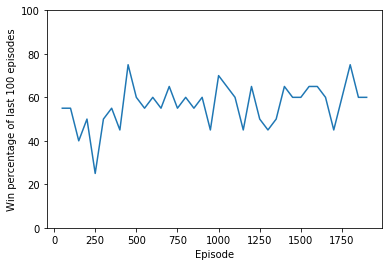

KeyboardInterrupt: 

In [25]:
AsyncSelfPlay(player = AC, n_games = 10000, n_envs = 100, test_each = 50, test_games = 20)